# Fine-tuning TrOCR on French handwriting

The released TrOCR model works best with English handwriting and needs to be fine-tuned to recognise French. It is (roughly) based on [the tutorial provided here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb).

This notebook fine-tunes TrOCR on the RIMES dataset. RIMES is licensed under the Creative Commons Attribution Non Commercial 4.0 International License and can be accessed [on Huggingface](https://huggingface.co/datasets/Teklia/RIMES-2011-line).

In [1]:
import pandas
from IPython.display import HTML, display
import PIL
import torch

In [2]:
import torch
using_gpu = torch.cuda.is_available()
print(using_gpu)

False


## Building the model

In [3]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor

/home/self/Documents/page-segment/trocr/venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
base_model_id = 'microsoft/trocr-small-handwritten'
processor = TrOCRProcessor.from_pretrained(base_model_id)

In [5]:
model = VisionEncoderDecoderModel.from_pretrained(base_model_id)

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

Before the model can be used, certain configuration parameters need to be set.

For details, see [the TrOCR fine-tuning tutorial](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb).

In [6]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# For now, take beam search parameters from the tutorial
model.generation_config.eos_token_id = processor.tokenizer.sep_token_id
model.generation_config.max_length = 64
model.generation_config.early_stopping = True
model.generation_config.no_repeat_ngram_size = 3
model.generation_config.length_penalty = 2.0
model.generation_config.num_beams = 2

Many (all?) of the Transformers loss functions are documented to ignore tokens with value `-100`. We'll later want the loss function to ignore padding. Notice that the padding token ID is currently **not** the `-100` value that we'll need to map it to:

In [7]:
processor.tokenizer.pad_token_id

1

# The data



In [8]:
from data_generator.download_fonts import download_fonts

download_fonts()

Total available font count: 64
image 2000 has been rendered
Example 2000: était couverte d'un linceul, dans


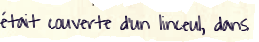

Lines/s: 33.01
Estimated time remaining: 1121s

image 4000 has been rendered
Example 4000: Nous passâmes le pont de Pélissier; là, le ravin que forme la


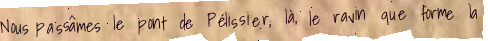

Lines/s: 33.99
Estimated time remaining: 1049s

image 6000 has been rendered
Example 6000: obtenir l'amitié.


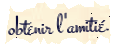

Lines/s: 33.46
Estimated time remaining: 1027s

image 8000 has been rendered
Example 8000: devais m'attendre à être sacrifié, ou à voir ceux que j'aimais le


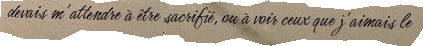

Lines/s: 33.33
Estimated time remaining: 992s

image 10000 has been rendered
Example 10000: ardeur l'espérance rentra dans mon cœur! Mes yeux furent remplis de


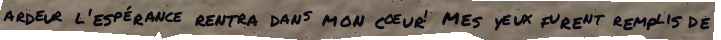

Lines/s: 33.38
Estimated time remaining: 952s

image 12000 has been rendered
Example 12000: encore au travail. Ses yeux


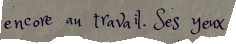

Lines/s: 33.79
Estimated time remaining: 901s

image 14000 has been rendered
Example 14000: obliquement celui qui porte le


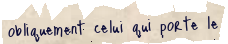

Lines/s: 34.39
Estimated time remaining: 843s

image 16000 has been rendered
Example 16000: couches supérieures.


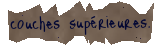

Lines/s: 34.79
Estimated time remaining: 792s

image 18000 has been rendered
Example 18000: terre, avec des dimensions phénoménales, des lycopodes hauts de


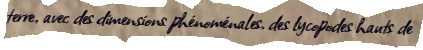

Lines/s: 35.10
Estimated time remaining: 744s

image 20000 has been rendered
Example 20000: Gigantostéologie, acheva de dire le professeur Lidenbrock


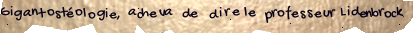

Lines/s: 35.51
Estimated time remaining: 695s

image 22000 has been rendered
Example 22000: permission de le faire imprimer, dans le but de nous présenter un jour


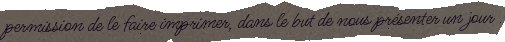

Lines/s: 35.76
Estimated time remaining: 648s

image 24000 has been rendered
Example 24000:  À quelle heure?


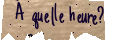

Lines/s: 35.70
Estimated time remaining: 612s

image 26000 has been rendered
Example 26000: plaisir de s'entendre; il parlait de toutes choses excepté de sciences,


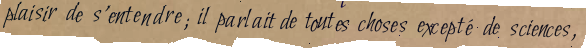

Lines/s: 35.80
Estimated time remaining: 573s

image 28000 has been rendered
Example 28000: Aramis qui causait avec la nocturne visiteuse, c'était une femme.


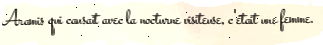

Lines/s: 35.98
Estimated time remaining: 532s

image 30000 has been rendered
Example 30000: aide et de son appui


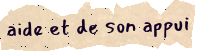

Lines/s: 36.19
Estimated time remaining: 491s

image 32000 has been rendered
Example 32000: gentilshommes. D'Artagnan, que l'on connaissait


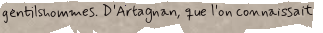

Lines/s: 36.35
Estimated time remaining: 451s

image 34000 has been rendered
Example 34000: avons fait un petit voyage.


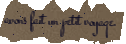

Lines/s: 36.57
Estimated time remaining: 410s

image 36000 has been rendered
Example 36000: je l'avoue,


Lines/s: 36.62
Estimated time remaining: 373s

image 38000 has been rendered
Example 38000: Créquy; une autre fois chez


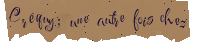

Lines/s: 36.81
Estimated time remaining: 333s

image 40000 has been rendered
Example 40000: aussi bon air qu'un cheval, et qu'il me semble qu'en vous procurant un


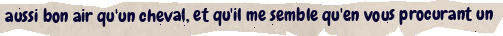

Lines/s: 36.94
Estimated time remaining: 294s

image 42000 has been rendered
Example 42000: rugissant d'une façon formidable.


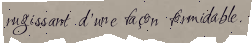

Lines/s: 37.11
Estimated time remaining: 256s

image 44000 has been rendered
Example 44000: très rigide, les a consignés


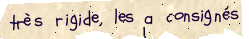

Lines/s: 37.20
Estimated time remaining: 218s

image 46000 has been rendered
Example 46000:  Je me le rappelle, dit d'Artagnan; vous disiez qu'après avoir demandé


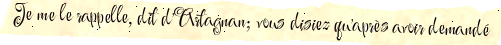

Lines/s: 37.30
Estimated time remaining: 180s

image 48000 has been rendered
Example 48000: moins, mais avec


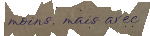

Lines/s: 37.41
Estimated time remaining: 142s

image 50000 has been rendered
Example 50000: donnera-t-il, si je suis innocente?


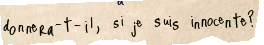

Lines/s: 37.42
Estimated time remaining: 107s

image 52000 has been rendered
Example 52000:  Je le connais.


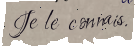

Lines/s: 37.47
Estimated time remaining: 70s

image 54000 has been rendered
Example 54000: Mme Bonacieux la regarda fuir, sans pouvoir la suivre; elle était comme


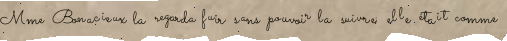

Lines/s: 37.57
Estimated time remaining: 33s

All tasks complete!


Map: 100%|██████████| 100/100 [00:01<00:00, 93.65 examples/s]


In [9]:
from dataset_builder import FineTuningDataset

data = FineTuningDataset(processor)

## Dataset preprocessing

The model that we'll fine-tune with `tensors` expects the data to have different column names. In a separate file, we:
- Convert to token IDs.
- Move data to the expected column names (`pixel_values` and `labels`).
- Preprocess the image.

It will be useful to access the original images later on. To allow this, the original datasets stay in `dataset_name_raw` and the mapped datasets are stored in `dataset_name`.

In [10]:
dataset_train = data.dataset_train
dataset_test = data.dataset_test

In [11]:
#print('Training example count', len(dataset_train))
first_item = next(iter(dataset_train))
print('First sample labels:', first_item['labels'].shape)
print('First sample pixel_values:', first_item['pixel_values'].shape)

first_item['labels']

/home/self/Documents/page-segment/trocr/venv/lib64/python3.12/site-packages/datasets/formatting/torch_formatter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


First sample labels: torch.Size([128])
First sample pixel_values: torch.Size([3, 384, 384])


tensor([    0,  8254,  1153,  3164,  1290, 22613,  1115, 10254,    11, 11736,
          318, 37233,   282, 44361,  1115, 10254,    11, 11736,   318, 20516,
         1019,    31,     5,     2,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])

# Inference pre fine-tuning

Let's get an idea of how well the model works before fine-tuning it on the RIMES dataset:

In [12]:
def run_inference(sample):
	batched = torch.unsqueeze(sample['pixel_values'], 0)
	if using_gpu:
		batched = batched.to(device='cuda')
	generated_labels = model.generate(batched)
	text = processor.batch_decode(generated_labels, skip_special_tokens=True)[0]
	return text

def run_model_on_examples():
	torch_iter = iter(dataset_test)
	raw_iter = iter(data.dataset_test_raw)
	for i in range(0, 10):
		torch_item = next(torch_iter)
		raw_item = next(raw_iter)
		print('---')
		img = raw_item['image'].copy()
		# Make the image smaller -- embedding large images with `display` makes the notebook
		# difficult to work with.
		img.thumbnail((300, 40))
		display(
			'Image:', img,
			'true:      {}'.format(raw_item['text']),
			'predicted: {}'.format(run_inference(torch_item))
		)


---


'Image:'

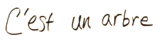

"true:      C'est un arbre"

'predicted: ( " best unweather .'

---


'Image:'

'true:      2002'

'predicted: wooz'

---


'Image:'

'true:      1999'

'predicted: wrapping'

---


'Image:'

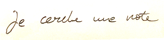

'true:      Je cerche une note'

'predicted: is the relationship .'

---


'Image:'

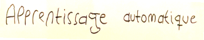

'true:      Apprentissage automatique'

'predicted: " It was an emergency investigation .'

---


'Image:'

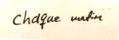

'true:      chaque matin'

'predicted: 2nd Representative .'

---


'Image:'

'true:      1994'

'predicted: regroup'

---


'Image:'

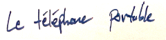

'true:      Le téléphone portable'

'predicted: appeared in the start of the time in the time of the 1960s in the'

---


'Image:'

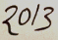

'true:      2013'

'predicted: yogis'

---


'Image:'

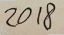

'true:      2018'

'predicted: 2018'

In [13]:

run_model_on_examples()

## Training

In [14]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
	predict_with_generate=True,
	evaluation_strategy='steps',
	fp16=True,
	output_dir="./model/",
	save_steps=500,
	eval_steps=50,
	logging_steps=20,
	logging_first_step=True,
	per_device_train_batch_size=8,
	per_device_eval_batch_size=8,
	max_steps=10_000,
)

/home/self/Documents/page-segment/trocr/venv/lib64/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
import evaluate, rapidfuzz
cer_metric = evaluate.load('cer')
wer_metric = evaluate.load('wer')

def compute_metrics(data):
	true_labels = data.label_ids
	predicted_labels = data.predictions

	true_labels[true_labels == -100] = processor.tokenizer.pad_token_id

	predicted_text = processor.batch_decode(predicted_labels, skip_special_tokens=True)
	label_text = processor.batch_decode(true_labels, skip_special_tokens=True)

	cer = cer_metric.compute(predictions=predicted_text, references=label_text)
	wer = wer_metric.compute(predictions=predicted_text, references=label_text)
	# Also compute a similarity ratio (which may be more intuitive than WER/CER)
	ratios = [ rapidfuzz.fuzz.ratio(predicted_text[i], label_text[i]) for i in range(0, len(predicted_text)) ]
	avg_ratio = sum(ratios)/len(ratios)

	return { 'cer': cer, 'wer': wer, 'ratio': avg_ratio }


In [16]:
small_eval_dataset = dataset_test.shuffle(seed=10).take(8)
large_eval_dataset = dataset_test.shuffle(seed=10).take(50)

In [17]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
	model=model,
	tokenizer=processor.image_processor,
	args=training_args,
	train_dataset=dataset_train,
	eval_dataset=small_eval_dataset,
	data_collator=default_data_collator,
	compute_metrics=compute_metrics,
)

/tmp/ipykernel_60555/1330022986.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
max_steps is given, it will override any value given in num_train_epochs


In [18]:
def evaluate_model():
	evaluation_data = trainer.evaluate(large_eval_dataset)
	print(evaluation_data)
	display(pandas.DataFrame.from_dict({
		'CER (Character Error Rate)': [evaluation_data['eval_cer']],
		'WER (Word Error Rate)': [evaluation_data['eval_wer']],
		'Average Similarity (%)': [evaluation_data['eval_ratio']],
		'Average seconds/sample (s)': [1/evaluation_data['eval_samples_per_second']],
		'Loss': [evaluation_data['eval_loss']],
	}, orient='index'))

display(HTML('<strong>Before fine-tuning:</strong>'))
evaluate_model()

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
  0%|          | 0/7 [00:00<?, ?it/s]Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
 29%|██▊       | 2/7 [00:10<00:25,  5.13s/it]Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
 43%|████▎     | 3/7 [00:17<00:23,  5.88s/it]Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
 57%|█████▋    | 4/7 [00:25<00:20,  6.81s/it]Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 12.502591133117676, 'eval_model_preparation_time': 0.0041, 'eval_cer': 1.067853170189099, 'eval_wer': 1.5806451612903225, 'eval_ratio': 27.678612498852484, 'eval_runtime': 54.2089, 'eval_samples_per_second': 0.922, 'eval_steps_per_second': 0.129}


,0
CER (Character Error Rate),1.067853
WER (Word Error Rate),1.580645
Average Similarity (%),27.678612
Average seconds/sample (s),1.084599
Loss,12.502591


In [19]:
trainer.train(resume_from_checkpoint=False)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/self/Documents/page-segment/trocr/venv/lib64/python3.12/site-packages/datasets/formatting/torch_formatter.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})
  0%|          | 1/10000 [00:08<24:32:41,  8.84s/it]

{'loss': 12.3738, 'grad_norm': 265.3468933105469, 'learning_rate': 4.9995000000000005e-05, 'epoch': 0.0}


  0%|          | 8/10000 [01:31<34:07:36, 12.30s/it]

KeyboardInterrupt: 

In [ ]:
display(HTML('<strong>After fine-tuning:</strong>'))

evaluate_model()

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 0.5915511846542358, 'eval_model_preparation_time': 0.0029, 'eval_cer': 0.08105560791705937, 'eval_wer': 0.2443820224719101, 'eval_ratio': 94.58795076454226, 'eval_runtime': 255.4081, 'eval_samples_per_second': 0.196, 'eval_steps_per_second': 0.027, 'epoch': 0.27}
{'eval_loss': 0.5915511846542358, 'eval_model_preparation_time': 0.0029, 'eval_cer': 0.08105560791705937, 'eval_wer': 0.2443820224719101, 'eval_ratio': 94.58795076454226, 'eval_runtime': 255.4081, 'eval_samples_per_second': 0.196, 'eval_steps_per_second': 0.027, 'epoch': 0.2718}


,0
CER (Character Error Rate),0.081056
WER (Word Error Rate),0.244382
Average Similarity (%),94.587951
Average seconds/sample (s),5.102041
Loss,0.591551


## Inference


---


'Image:'

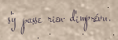

"true:      s'y passe rien d'imprévu."

"predicted: s'y passe rien d'imprrêm."

---


'Image:'

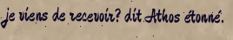

'true:      je viens de recevoir? dit Athos étonné.'

'predicted: je viens de recevoir? dit Athos étonné.'

---


'Image:'

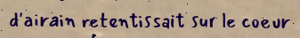

"true:      d'airain retentissait sur le coeur"

"predicted: d'airain retentissait sur le coeur"

---


'Image:'

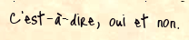

"true:       C'est-à-dire, oui et non."

"predicted: C'est à t-dire, oui et non."

---


'Image:'

'true:      société, je voulus aussi voir des montagnes, des torrents, et toutes'

'predicted: sapitaté je voulas aussi noir des montagnes, des torrents, et toutes'

---


'Image:'

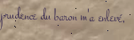

"true:      prudence du baron m'a enlevé,"

"predicted: prudence du baron m'a enlevé,"

---


'Image:'

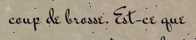

'true:      coup de brosse. Est-ce que'

'predicted: coup de brosse, Est-ce que'

---


'Image:'

"true:      la forme peu scientifique d'un juron.  De là, grande colère."

"predicted: la furne peu sciontifique d'un jouron. De la grande coère:"

---


'Image:'

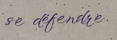

'true:      se défendre.'

'predicted: se défendre.'

---


'Image:'

"true:      vivres; toi, Axel, d'un second tiers des vivres et des armes;"

"predicted: vivres; tui. Araît d'un second tous des virus et des arnes;"

In [ ]:
run_model_on_examples()


The above examples seem to be recognized mostly correctly. Next, testing on images *not* in the style of the training data:

In [ ]:

import glob, html

def path_to_sample(file_path: str):
	with PIL.Image.open(file_path) as image:
		return data.data_row_to_torch({
			'image': image,
			'text': '[no expected text]'
		})

def infer_all():
	images_col = []
	predicted_col = []
	paths = list(glob.glob('../custom-samples/*.png'))
	for i in range(0, len(paths), 8):
		pytorch_samples = [ ]
		for j in range(i, min(i + 8, len(paths))):
			pytorch_samples.append(path_to_sample(paths[j])['pixel_values'])
		batch = torch.stack(pytorch_samples)
		print(batch.shape)
		generated_labels = model.generate(batch)
		predicted_col += list(processor.batch_decode(generated_labels, skip_special_tokens=True))

	for path in paths:
		print(path)
		images_col.append('<img src="{}" width="320"/>'.format(html.escape(path)))

	display(HTML(pandas.DataFrame({ 'image': images_col, 'predicted': predicted_col }).to_html(escape=False)))
infer_all()

torch.Size([8, 3, 384, 384])
torch.Size([7, 3, 384, 384])
../custom-samples/sample_1.png
../custom-samples/sample_2.png
../custom-samples/sample_3.png
../custom-samples/sample_4.png
../custom-samples/sample_5.png
../custom-samples/sample_6.png
../custom-samples/sample_7.png
../custom-samples/sample_8.png
../custom-samples/sample_9.png
../custom-samples/sample_10.png
../custom-samples/sample_11.png
../custom-samples/sample_12.png
../custom-samples/sample_13.png
../custom-samples/sample_14.png
../custom-samples/sample_15.png


,image,predicted
0,,j'étaiche. J'ençais
1,,J'étuune franceux
2,,Ketouche fragoise...
3,,Ketuière fragouse...
4,,Ketuière francaise...
5,,J'Artagnan dans la
6,,J'étaitre-faissée-mêt
7,,C'est un autre exemat.
8,,C'est un aut exongle.
9,,F'est un autre exoppé.


# Citations

```
@misc{li2021trocr,
      title={TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models}, 
      author={Minghao Li and Tengchao Lv and Lei Cui and Yijuan Lu and Dinei Florencio and Cha Zhang and Zhoujun Li and Furu Wei},
      year={2021},
      eprint={2109.10282},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}

Grosicki, E., Carré, M., Geoffrois, E., Augustin, E., Preteux, F., & Messina, R. (2024). RIMES, complete [Data set]. Mitek Systems, Inc. https://doi.org/10.5281/zenodo.10812725

```